# Show "best fit" high-pressure limit kinetics 
Run this script once to identify a list of reactions including indices that produce the highest 
rates per reaction family for unimolecular and bimolecular reactions. Based on the result, 
improve the database and run the script again. Repeat this process until the "best fit" 
high-pressure limit kinetics show "reasonable" rates.

In [1]:
import os
import time
import operator
import unittest 
import numpy as np
from copy import deepcopy

from rmgpy import settings
from rmgpy.data.kinetics.database import KineticsDatabase
from rmgpy.data.base import DatabaseError
from rmgpy.molecule.molecule import Molecule
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics.common import KineticsError, saveEntry
from rmgpy.kinetics.arrhenius import Arrhenius
from rmgpy.data.rmg import getDB

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


## Step 1: 
Select the family to work on.

In [2]:
#path = os.path.join(settings['database.directory'], 'kinetics','families')
database = RMGDatabase()
database.load(
    settings['database.directory'], 
    thermoLibraries = ['primaryThermoLibrary','Klippenstein_Glarborg2016','BurkeH2O2','thermo_DFT_CCSDTF12_BAC','CBS_QB3_1dHR', 'DFT_QCI_thermo'],
    transportLibraries = [],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsFamilies = 'all',
    kineticsDepositories = ['training'],
    depository = False,  
)

In [3]:
#all_families = getDB('kinetics').families.keys()
all_families = ['1,2_Insertion_carbene']

# Discrete temperature range
Ts = np.linspace(300,2000,30)

## Step 2a: unimolecular reactions 
Generate a list of reactions including indices that produce the highest rates per reaction family for unimolecular reactions.

1,2_Insertion_carbene


/Users/agnes/PycharmProjects/RMG-Py/rmgpy/tools/plot.py:36: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in laun

For 3.33333333333 1/K training reaction CH2 + CH3CCH_r2 <=> CH3CH2CCH with index 3 has the highest rate 
                    of 1.75658847282e-62.
For 2.78846153846 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                    of 8.33175744419e-50.
For 2.39669421488 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                    of 1.11159880451e-40.
For 2.10144927536 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                    of 8.15189171597e-34.
For 1.87096774194 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                    of 1.82613922829e-28.
For 1.68604651163 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the highest rate 
                    of 3.52292043182e-24.
For 1.53439153439 1/K training reaction CH2 + CH3CHCH2_r3 <=> CH3CH2CHCH2 with index 6 has the hig

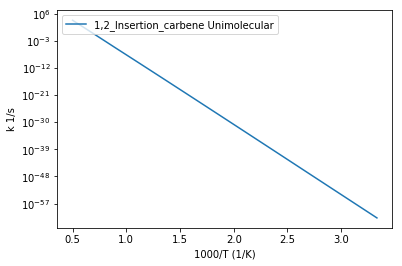

In [4]:
for fam_name in all_families:
    print fam_name
    # Generate training reactions only for non-surface families
    if 'Surface' not in fam_name:
        fam = database.kinetics.families[fam_name]
        dep = fam.getTrainingDepository()
        rxns = []
        list_indices = []
        
        # Extract all training reactions for selected family
        for entry in dep.entries.values():
            r = entry.item
            r.kinetics = entry.data
            for spc in r.reactants+r.products:
                if spc.thermo is None:
                    spc.thermo = database.thermo.getThermoData(spc)
            rxns.append(r)
        
        # Only proceed if at least one training reaction is available
        if rxns:         
            # Get kinetic rates for unimolecular reactions
            kunim = []
            for ind_rxn, rxn in enumerate(rxns):
                if len(rxn.reactants) == 1:
                    kunim.append(rxn.kinetics)
                    list_indices.append(ind_rxn)
                if len(rxn.products) == 1:
                    kunim.append(rxn.generateReverseRateCoefficient())
                    list_indices.append(ind_rxn)
                        
            # Get max. kinetic rates at each discrete temperature
            if kunim:
                kunimaxes = []
                for T in Ts:
                    mydict = {}
                    kvals = [k.getRateCoefficient(T) for k in kunim]
                    mydict = dict(zip(list_indices, kvals))
                
                    # Find key and value of max rate coefficient
                    key_max_rate = max(mydict.iteritems(), key=operator.itemgetter(1))[0]
                    kval = mydict[key_max_rate]
                    kunimaxes.append(kval)
                    print """For {0} 1/K training reaction {1} with index {2} has the highest rate 
                    of {3}.""".format(1000.0/T, dep.entries.get(key_max_rate), key_max_rate, kval)
        
                arruni = Arrhenius().fitToData(Ts,np.array(kunimaxes),'s^-1')
    
                fig = plt.figure()
                fig_name =  fam_name 
                #save_path = 'ArrheniusFig/'
                plt.semilogy(1000.0/Ts,kunimaxes, label = (fig_name + ' Unimolecular'))
                plt.xlabel("1000/T (1/K)")
                plt.ylabel("k 1/s")
                plt.legend(loc='upper left')
                #fig.savefig((save_path + fig_name + '_Unimolecular' + '.png'), bbox_inches='tight')
                #plt.close("all")
        else:
            print "No training reaction available for family {0}".format(fam_name)

## Step 2b: bimolecular reactions 
Generate a list of reactions including indices that produce the highest rates per reaction family for bimolecular reactions.

For 3.33333333333 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 116382243.665.
For 2.78846153846 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 78180075.7694.
For 2.39669421488 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 58362392.4532.
For 2.10144927536 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 46601462.6868.
For 1.87096774194 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 38949711.543.
For 1.68604651163 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 33629757.7345.
For 1.53439153439 1/K training reaction CH2 + benzene <=> toluene with index 11 has the highest rate 
                    of 29741651.7639.
For 1.40776699029 1/K

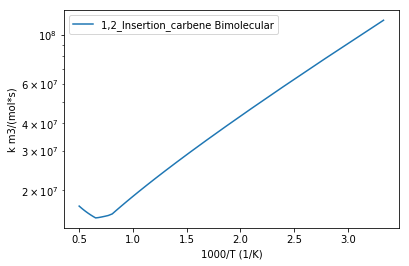

In [5]:
for fam_name in all_families:
    
    # Generate training reactions only for non-surface families
    if 'Surface' not in fam_name:
        fam = database.kinetics.families[fam_name]
        dep = fam.getTrainingDepository()
        rxns = []
        list_indices = []
        
        # Extract all training reactions for selected family
        for entry in dep.entries.values():
            r = entry.item
            r.kinetics = entry.data
            for spc in r.reactants+r.products:
                if spc.thermo is None:
                    spc.thermo = database.thermo.getThermoData(spc)
            rxns.append(r)
        
        # Only proceed if at least one training reaction is available
        if rxns:         
            # Get kinetic rates for unimolecular reactions
            kbim = []
            for ind_rxn, rxn in enumerate(rxns):
                if len(rxn.reactants) == 2:
                    kbim.append(rxn.kinetics)
                    list_indices.append(ind_rxn)
                if len(rxn.products) == 2:
                    kbim.append(rxn.generateReverseRateCoefficient())
                    list_indices.append(ind_rxn)
                        
            # Get max. kinetic rates at each discrete temperature
            if kbim:
                kbimaxes = []
                for T in Ts:
                    mydict = {}
                    kvals = [k.getRateCoefficient(T) for k in kbim]
                    mydict = dict(zip(list_indices, kvals))
                
                    # Find key and value of max rate coefficient
                    key_max_rate = max(mydict.iteritems(), key=operator.itemgetter(1))[0]
                    kval = mydict[key_max_rate]
                    kbimaxes.append(kval)
                    print """For {0} 1/K training reaction {1} with index {2} has the highest rate 
                    of {3}.""".format(1000.0/T, dep.entries.get(key_max_rate), key_max_rate, kval)
        
                arrbi = Arrhenius().fitToData(Ts,np.array(kbimaxes),'m^3/(mol*s)')
    
                fig = plt.figure()
                fig_name =  fam_name 
                #save_path = 'ArrheniusFig/'
                plt.semilogy(1000.0/Ts,kbimaxes, label = (fig_name + ' Bimolecular') )
                plt.xlabel("1000/T (1/K)")
                plt.ylabel("k m3/(mol*s)")
                plt.legend(loc='upper left')
                #fig.savefig((save_path + fig_name + '_Bimolecular' + '.png'), bbox_inches='tight')
                #plt.close("all")
        else:
            print "No training reaction available for family {0}".format(fam_name)